# Merge Heterogeneous graph datasets

Merge the created Heterogeneous graph datasets using a binary tree merge approach

In [1]:
# Torch
import torch
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.data import Dataset, Data

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
from math import floor, ceil
from joblib import dump, load
import time
import os

# Pandas display options
pd.set_option('display.max_columns', 1300)
pd.set_option('display.max_rows', 100)

In [2]:
# Graph related path constants
PATH_HETERO_GRAPH_DATASET_FOLDER = '../../data/graph-dataset/semester-2/hetero-graph/'

# Graph dataset class
class InfernoDataset(Dataset):
    def __init__(self, data_list):
        super(InfernoDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]
    
    def concat(self, dataset):
        self.data_list = self.data_list + dataset.data_list

## 1. Optimization

Calculate the efficiency (time of operation) of different file concatenation startegies and compare which is best to use. Used strategies:
  - Continuous concatenation
  - Binary tree approach
  - N-ary tree (generalization of binary tree).

There are some basic assumptions in order to calculate the efficiency (time) of the operations:
  - ***N*** ∈ [0, ∞): number of files,
  - ***S<sub>i<sub>*** = 1: Size of the *i*-th file (always equals 1),
  - ***T<sub>r<sub>i</sub></sub>*** = ***S<sub>i<sub>*** *sec*: Time needed to read the *i*-th file,
  - ***T<sub>concat<sub>*** = 1 *sec*: Concatenation time (fixed to 1 second),
  - ***T<sub>w<sub>new<sub></sub>*** = ***S<sub>new<sub>*** *sec*: Time needed to write the concatenated file.
  
Using this, the time needed to concatenate 2 files is given by:

***T<sub>all<sub>*** = (***T<sub>r<sub>i</sub></sub>*** + ***T<sub>r<sub>i+1</sub></sub>***) + ***T<sub>concat<sub>*** + ***T<sub>w<sub>new</sub></sub>***

Using the base values, we can calculate how much time the simplest concatenation takes: 2 files, each with ***S*** = 1:

***T<sub>all<sub>*** = (1 + 1) + 1 + 2 = 5

----
### 1. Continuous concatenation

Can be define by the following geometric series:

***a<sub>n<sub>*** = ***a<sub>n-1<sub>*** + ***d***

where ***d*** = 2 and ***a<sub>1<sub>*** = 5. From this, the needed time is the sum of the first ***N*** values of the geometric series:

$T_{\text{all},N} = S_N = \frac{(2 a_1 + (n - 1) \cdot d) \cdot n}{2}$

----
### 2. Binary tree

Can be defined by the following equasion:

$T_{\text{all},N} = \sum_{i=0}^{h-1} 2^i \cdot (2^{h - i + 1} + 1)$


----
### 3. K-ary tree

The generalization of the binary tree approach. Can be defined by the following equasion:

$T_{\text{all},N} = \sum_{i=0}^{h-1} k^i \cdot (2 \cdot k^{h - i} + 1)$


----
### Plotting these functions to compare effectiveness

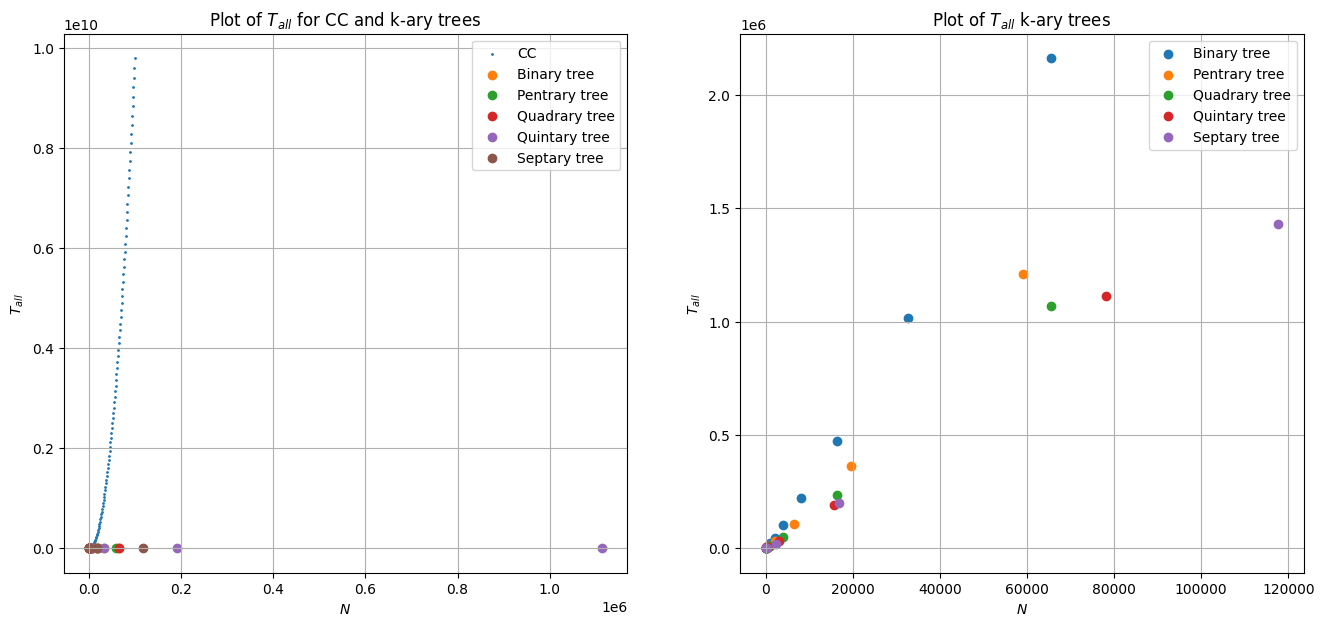

In [46]:
# Continuous concatenation approach
def arithmetic_series_sum(a1, d, N):
    # a1: első tag
    # d: differencia
    # N: hány tag összege
    sums = []
    for n in range(1, N, 1000):
        sum_n = n * (2 * a1 + (n - 1) * d) // 2
        sums.append(sum_n)
    return sums

# K-ary tree approach
def k_ary_tree_sum(k, n):
    # Height of tree
    h = ceil(np.emath.logn(k, n))
    total = 0
    # i = 0 to h - 1 (since the range is exclusive of the last element, I simply use h)
    for i in range(0, h):
        total += (k**i * (2 * k**(h - i) + 1))
    return total

# Parameters
a1 = 5
d = 2

# First N terms
N = 100000

# CC sums
cc_sums = arithmetic_series_sum(a1, d, N)

binary_tree_sums_arr   = np.power(2, np.arange(1, ceil(np.emath.logn(2, 120000))))
ternary_tree_sums_arr  = np.power(3, np.arange(1, ceil(np.emath.logn(3, 120000))))
quadrary_tree_sums_arr = np.power(4, np.arange(1, ceil(np.emath.logn(4, 120000))))
quintary_tree_sums_arr = np.power(5, np.arange(1, ceil(np.emath.logn(5, 120000))))
septary_tree_sums_arr  = np.power(7, np.arange(1, ceil(np.emath.logn(7, 120000))))

binary_tree_sums_result   = [k_ary_tree_sum(2, n) for n in binary_tree_sums_arr]
ternary_tree_sums_result  = [k_ary_tree_sum(3, n) for n in ternary_tree_sums_arr]
quadrary_tree_sums_result = [k_ary_tree_sum(4, n) for n in quadrary_tree_sums_arr]
quintary_tree_sums_result = [k_ary_tree_sum(5, n) for n in quintary_tree_sums_arr]
septary_tree_sums_result =  [k_ary_tree_sum(7, n) for n in septary_tree_sums_arr]

# Python calculation error fix
quintary_tree_sums_result[5] = 191406
septary_tree_sums_result[4] = 200871

# Plot
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
axs[0].scatter(range(0, N, 1000), cc_sums, label='CC', s=1)
axs[0].scatter(binary_tree_sums_arr, binary_tree_sums_result, label='Binary tree')
axs[0].scatter(ternary_tree_sums_arr, ternary_tree_sums_result, label='Pentrary tree')
axs[0].scatter(quadrary_tree_sums_arr, quadrary_tree_sums_result, label='Quadrary tree')
axs[0].scatter(quintary_tree_sums_result, quintary_tree_sums_result, label='Quintary tree')
axs[0].scatter(septary_tree_sums_arr, septary_tree_sums_result, label='Septary tree')
axs[0].set_xlabel('$N$')
axs[0].set_ylabel('$T_{all}$')
axs[0].set_title('Plot of $T_{all}$ for CC and k-ary trees')
axs[0].legend()
axs[0].grid(True)

axs[1].scatter(binary_tree_sums_arr, binary_tree_sums_result, label='Binary tree')
axs[1].scatter(ternary_tree_sums_arr, ternary_tree_sums_result, label='Pentrary tree')
axs[1].scatter(quadrary_tree_sums_arr, quadrary_tree_sums_result, label='Quadrary tree')
axs[1].scatter(quintary_tree_sums_arr, quintary_tree_sums_result, label='Quintary tree')
axs[1].scatter(septary_tree_sums_arr, septary_tree_sums_result, label='Septary tree')
axs[1].set_xlabel('$N$')
axs[1].set_ylabel('$T_{all}$')
axs[1].set_title('Plot of $T_{all}$ k-ary trees')
axs[1].legend()
axs[1].grid(True)

plt.show()

It is visible from the plots above that the CC approach is a lot more costly than the the k-ary tree approaches. It is also visible that (since both functions are sums), they are discrate. Along these examinations, a pattern arises when plotting k-ary tree approach times for multiple different k values: the higher k is, the more the function flattens. This is due to the fact that for a fixed N number of files, merging in an k-ary tree is always faster than a k-1-ary tree, assuming an infinite amount of memory. In order to show this, the summation functions had to be transformed into continuous functions. I did this by replacing the sum with an integral that goes from 0 to ${log_k N}$ (notice how the ceil function dissappeared from this latter term; that is because in the discrate case, it resembled the tree hight, however, when doing integration, the real value can be interpreted as well). This is a legal move, since an integral is an upper estimation of a sum. After this the equasion looked like this:

$T_{\text{all},N} = \int_{i=0}^{(log_k N) - 1} k^i \cdot (2 \cdot k^{{log_k N} - i} + 1)  di $ = $\frac{-k + n - 2\cdot k\cdot n\cdot ln(k) + 2\cdot k\cdot n\cdot ln(n)}{k\cdot ln(k)}$

C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\980409424.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\980409424.py:3: RuntimeWarning: invalid value encountered in multiply
  plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\980409424.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\980409424.py:5: RuntimeWarning: invalid value encountered in multiply
  plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\980409424.py:7: RuntimeWarning: divide by zero encountered in log
  plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), lab

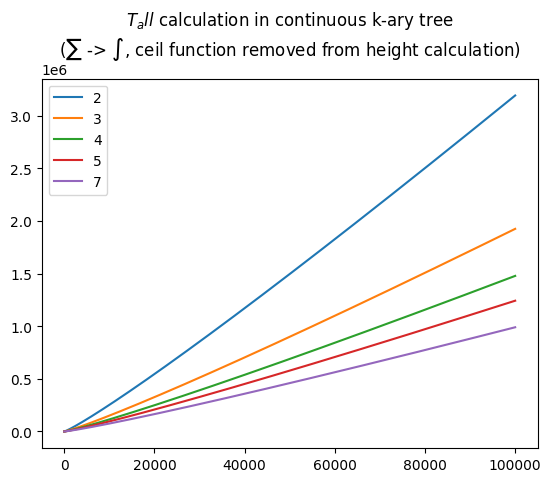

In [38]:
n = np.linspace(0, 100000, 100001)
k = 2
plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
k = 3
plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
k = 4
plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
k = 5
plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
k = 7
plt.plot(n, (-k + n - 2*k*n*np.log(k) + 2*k*n*np.log(n))/(k*np.log(k)), label = k)
plt.title('$T_all$ calculation in continuous k-ary tree\n($\sum$ -> $\int$, ceil function removed from height calculation)')
plt.legend()

If we take the derivative of these functios we can examine the trend of growth. 

$\int_{i=0}^{(log_k N) - 1} k^i \cdot (2 \cdot k^{{log_k N} - i} + 1) di \frac{\partial}{\partial n} $ =
$\frac{1 + 2 \cdot k - 2\cdot k\cdot ln(k) + 2\cdot k\cdot ln(n)}{(k\cdot ln(k))}$

For a fix the number of files to a random positive integer N = $n_i$, we can take the limit of the derivative to show that it converges to 0:

$\lim_{k \to \infty }$ $\frac{1 + 2 \cdot k - 2\cdot k\cdot ln(k) + 2\cdot k\cdot ln(n)}{(k\cdot ln(k))}$ = 0

(Side note that checking the limit from k = 0 to infinity is not valid for all values of k, since the number of files $n_i$ holds as an upper limit; above this, the k will act as if it were $n_i$).

C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\2883988207.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(k, (1 + 2*k - 2*k*np.log(k) + 2*k*np.log(n))/(k*np.log(k)))
C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\2883988207.py:4: RuntimeWarning: invalid value encountered in multiply
  plt.plot(k, (1 + 2*k - 2*k*np.log(k) + 2*k*np.log(n))/(k*np.log(k)))
C:\Users\szmid\AppData\Local\Temp\ipykernel_8308\2883988207.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(k, (1 + 2*k - 2*k*np.log(k) + 2*k*np.log(n))/(k*np.log(k)))


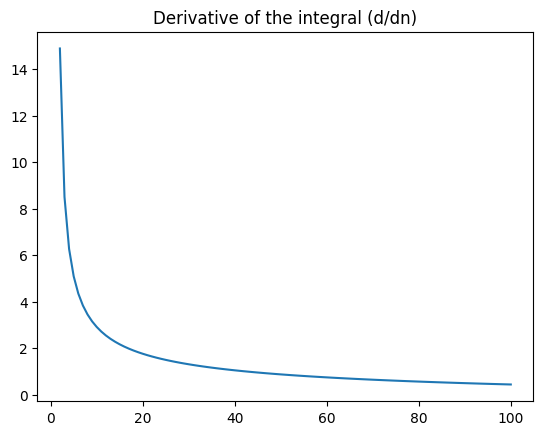

In [48]:
k = np.linspace(0, 100, 101)
n = 100
plt.title("Derivative of the integral (d/dn)")
plt.plot(k, (1 + 2*k - 2*k*np.log(k) + 2*k*np.log(n))/(k*np.log(k)))

## 2. Concat dataframes

### 1. Concate single datasets in pairs of two

In [10]:
file_list = os.listdir(PATH_HETERO_GRAPH_DATASET_FOLDER)
file_list = [f for f in file_list if f.endswith('.pt')]

for i in range(0, len(file_list), 2):
    try:
        dataset = InfernoDataset(
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + file_list[i]).data_list +
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + file_list[i+1]).data_list
        )
        file_name = file_list[i].split('.')[0][-4:] + '-' + file_list[i+1].split('.')[0][-4:]
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-2/' + file_name + '.pt')
        print('Merged', file_list[i], file_list[i+1])
    except:
        print('Error in merging last file. Copying it as is.')
        dataset = torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + file_list[i])
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-2/' + file_list[i].split('.')[0][-4:] + '.pt')

Merged inferno_graph_data_00-1000.pt inferno_graph_data_01-1001.pt
Merged inferno_graph_data_01-1002.pt inferno_graph_data_01-1003.pt
Merged inferno_graph_data_01-1004.pt inferno_graph_data_01-1005.pt
Merged inferno_graph_data_02-1006.pt inferno_graph_data_02-1007.pt
Merged inferno_graph_data_02-1008.pt inferno_graph_data_02-1009.pt
Merged inferno_graph_data_02-1010.pt inferno_graph_data_03-1011.pt
Merged inferno_graph_data_03-1012.pt inferno_graph_data_03-1013.pt
Merged inferno_graph_data_03-1014.pt inferno_graph_data_04-1015.pt
Merged inferno_graph_data_04-1016.pt inferno_graph_data_04-1017.pt
Merged inferno_graph_data_04-1018.pt inferno_graph_data_04-1019.pt
Merged inferno_graph_data_05-1020.pt inferno_graph_data_05-1021.pt
Merged inferno_graph_data_05-1022.pt inferno_graph_data_05-1023.pt
Merged inferno_graph_data_05-1024.pt inferno_graph_data_06-1025.pt
Merged inferno_graph_data_06-1026.pt inferno_graph_data_06-1027.pt
Merged inferno_graph_data_06-1028.pt inferno_graph_data_06-102

### 2. Concat double datasets into pairs of four

In [ ]:
file_list = os.listdir(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-2/')
file_list = [f for f in file_list if f.endswith('.pt')]

for i in range(0, len(file_list), 2):
    try:
        dataset = InfernoDataset(
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-2/' + file_list[i]).data_list +
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-2/' + file_list[i+1]).data_list
        )
        file_name = file_list[i].split('.')[0] + '-' + file_list[i+1].split('.')[0]
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-4/' + file_name + '.pt')
        print('Merged', file_list[i], file_list[i+1])
    except:
        print('Error in merging last file. Copying it as is.')
        dataset = torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-2/' + file_list[i])
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-4/' + file_list[i].split('.')[0] + '.pt')

### 3. Concat quadruple datasets into pairs of eight

In [52]:
file_list = os.listdir(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-4/')
file_list = [f for f in file_list if f.endswith('.pt')]

for i in range(0, len(file_list), 2):
    try:
        dataset = InfernoDataset(
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-4/' + file_list[i]).data_list +
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-4/' + file_list[i+1]).data_list
        )
        file_name = file_list[i].split('.')[0] + '-' + file_list[i+1].split('.')[0]
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-8/' + file_name + '.pt')
        print('Merged', file_list[i], file_list[i+1])
    except:
        print('Error in merging last file. Copying it as is.')
        dataset = torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-4/' + file_list[i])
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-8/' + file_list[i].split('.')[0] + '.pt')

Merged 1000-1001-1002-1003.pt 1004-1005-1006-1007.pt
Merged 1008-1009-1010-1011.pt 1012-1013-1014-1015.pt
Merged 1016-1017-1018-1019.pt 1020-1021-1022-1023.pt
Merged 1024-1025-1026-1027.pt 1028-1029-1030-1031.pt
Merged 1032-1033-1034-1035.pt 1036-1037-1038-1039.pt
Merged 1040-1041-1042-1043.pt 1044-1045-1046-1047.pt
Merged 1048-1049-1050-1051.pt 1052-1053-1054-1055.pt
Merged 1056-1057-1058-1059.pt 1060-1061-1062-1063.pt
Merged 1064-1065-1066-1067.pt 1068-1069-1070-1071.pt
Merged 1072-1073-1074-1075.pt 1076-1077-1078-1079.pt
Merged 1080-1081-1082-1083.pt 1084-1085-1086-1087.pt
Merged 1088-1089-1090-1091.pt 1092-1093-1094-1095.pt
Merged 1096-1097-1098-1099.pt 1100-1101-1102-1103.pt
Merged 1104-1105-1106-1107.pt 1108-1109-1110-1111.pt
Merged 1112-1113-1114-1115.pt 1116-1117-1118-1119.pt
Merged 1120-1121-1122-1123.pt 1124-1125-1126-1127.pt
Merged 1128-1129-1130-1131.pt 1132-1133.pt


### 4. Concat octuple datasets into pairs of sixteen

In [95]:
file_list = os.listdir(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-8/')
file_list = [f for f in file_list if f.endswith('.pt')]

for i in range(0, len(file_list), 2):
    try:
        dataset = InfernoDataset(
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-8/' + file_list[i]).data_list +
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-8/' + file_list[i+1]).data_list
        )
        file_name = file_list[i].split('.')[0] + '-' + file_list[i+1].split('.')[0]
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-16/' + file_name + '.pt')
        print('Merged', file_list[i], file_list[i+1])
    except:
        print('Error in merging last file. Copying it as is.')
        dataset = torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-8/' + file_list[i])
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-16/' + file_list[i].split('.')[0] + '.pt')

Merged 1000-1001-1002-1003-1004-1005-1006-1007.pt 1008-1009-1010-1011-1012-1013-1014-1015.pt
Merged 1016-1017-1018-1019-1020-1021-1022-1023.pt 1024-1025-1026-1027-1028-1029-1030-1031.pt
Merged 1032-1033-1034-1035-1036-1037-1038-1039.pt 1040-1041-1042-1043-1044-1045-1046-1047.pt
Merged 1048-1049-1050-1051-1052-1053-1054-1055.pt 1056-1057-1058-1059-1060-1061-1062-1063.pt
Merged 1064-1065-1066-1067-1068-1069-1070-1071.pt 1072-1073-1074-1075-1076-1077-1078-1079.pt
Merged 1080-1081-1082-1083-1084-1085-1086-1087.pt 1088-1089-1090-1091-1092-1093-1094-1095.pt
Merged 1096-1097-1098-1099-1100-1101-1102-1103.pt 1104-1105-1106-1107-1108-1109-1110-1111.pt
Merged 1112-1113-1114-1115-1116-1117-1118-1119.pt 1120-1121-1122-1123-1124-1125-1126-1127.pt
Error in merging last file. Copying it as is.


In [96]:
file_list = os.listdir(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-16/')
file_list = [f for f in file_list if f.endswith('.pt')]

for i in range(0, len(file_list), 2):
    try:
        dataset = InfernoDataset(
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-16/' + file_list[i]).data_list +
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-16/' + file_list[i+1]).data_list
        )
        file_name = file_list[i].split('.')[0] + '-' + file_list[i+1].split('.')[0]
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-32/' + file_name + '.pt')
        print('Merged', file_list[i], file_list[i+1])
    except:
        print('Error in merging last file. Copying it as is.')
        dataset = torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-16/' + file_list[i])
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-32/' + file_list[i].split('.')[0] + '.pt')

Merged 1000-1001-1002-1003-1004-1005-1006-1007-1008-1009-1010-1011-1012-1013-1014-1015.pt 1016-1017-1018-1019-1020-1021-1022-1023-1024-1025-1026-1027-1028-1029-1030-1031.pt
Merged 1032-1033-1034-1035-1036-1037-1038-1039-1040-1041-1042-1043-1044-1045-1046-1047.pt 1048-1049-1050-1051-1052-1053-1054-1055-1056-1057-1058-1059-1060-1061-1062-1063.pt
Merged 1064-1065-1066-1067-1068-1069-1070-1071-1072-1073-1074-1075-1076-1077-1078-1079.pt 1080-1081-1082-1083-1084-1085-1086-1087-1088-1089-1090-1091-1092-1093-1094-1095.pt
Merged 1096-1097-1098-1099-1100-1101-1102-1103-1104-1105-1106-1107-1108-1109-1110-1111.pt 1112-1113-1114-1115-1116-1117-1118-1119-1120-1121-1122-1123-1124-1125-1126-1127.pt
Error in merging last file. Copying it as is.


In [ ]:
file_list = os.listdir(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-32/')
file_list = [f for f in file_list if f.endswith('.pt')]

for i in range(0, len(file_list), 2):
    try:
        dataset = InfernoDataset(
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-32/' + file_list[i]).data_list +
            torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-32/' + file_list[i+1]).data_list
        )
        file_name = file_list[i].split('.')[0] + '-' + file_list[i+1].split('.')[0]
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-64/' + file_name + '.pt')
        print('Merged', file_list[i], file_list[i+1])
    except Exception as e:
        print('Error in merging last file. Copying it as is.')
        print('Exception: ', e)
        dataset = torch.load(PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-32/' + file_list[i])
        torch.save(dataset, PATH_HETERO_GRAPH_DATASET_FOLDER + 'merged-64/' + file_list[i].split('.')[0] + '.pt')